In [52]:
%reload_ext autotime

import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
from scipy import interpolate
from scipy import stats
from datetime import datetime, timedelta
import pytz
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects
print(SDS_download.__file__)
import geopandas as gpd
import tqdm.auto as tqdm
from glob import glob
import ee
from shapely.ops import split
from shapely import line_merge
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

/home/ubuntu/.local/lib/python3.10/site-packages/coastsat/SDS_download.py


In [2]:
service_account = 'service-account@iron-dynamics-294100.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, '.private-key.json')
ee.Initialize(credentials)

In [53]:
sitename = "nzd0284"
def read(f):
    vos = pd.read_csv(f)
    vos.drop(columns="Unnamed: 0", inplace=True)
    vos.set_index("dates", inplace=True)
    vos.index = pd.to_datetime(vos.index)
    return vos
vos = read(f"shoreline_data_run6/New_Zealand/{sitename}/time_series_raw.csv")
vos

,nzd0284-0000,nzd0284-0001,nzd0284-0002,nzd0284-0003,nzd0284-0004,nzd0284-0005,nzd0284-0006,nzd0284-0007,nzd0284-0008,nzd0284-0009,...,nzd0284-0160,nzd0284-0161,nzd0284-0162,nzd0284-0163,nzd0284-0164,nzd0284-0165,nzd0284-0166,nzd0284-0167,nzd0284-0168,nzd0284-0169
dates,,,,,,,,,,,,,,,,,,,,,
1999-08-12 21:53:08+00:00,225.672085,240.611752,NaN,248.514382,230.908127,245.152781,247.123435,246.162949,NaN,250.736573,...,220.045896,210.542434,198.098205,202.030803,195.175936,199.118148,196.975767,189.508455,191.490051,186.137322
1999-08-21 21:46:56+00:00,NaN,224.469439,227.084409,225.755579,215.174117,237.142117,234.190403,217.892180,178.622034,212.071016,...,201.395533,192.236240,191.924443,183.123843,182.370302,184.548078,183.939658,180.460468,177.199443,175.118012
1999-08-28 21:53:11+00:00,NaN,228.086885,231.968908,227.875870,220.432060,230.904187,231.917194,229.922230,177.233092,NaN,...,209.016054,196.336047,189.040758,186.865301,176.595768,180.026945,175.635656,174.212202,170.529786,166.378374
1999-09-22 21:47:00+00:00,231.997410,227.986219,231.586033,NaN,228.507578,NaN,241.047516,242.970918,242.358879,246.471697,...,214.139935,210.263443,200.850139,198.197778,194.308761,190.168852,193.591050,189.777891,186.110419,181.318200
1999-09-29 21:53:16+00:00,217.731400,224.474711,NaN,224.013945,219.774788,232.584819,232.094375,NaN,227.557433,235.371919,...,203.215939,196.236235,189.656977,189.090741,189.842713,186.784273,183.397888,178.924913,166.165749,159.412826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-07 20:43:48+00:00,203.704462,208.014264,215.567371,NaN,NaN,208.333828,NaN,NaN,NaN,NaN,...,209.935805,207.548287,196.040661,201.493086,200.098926,198.816274,186.307545,181.611780,175.611040,NaN
2021-12-22 22:00:33+00:00,NaN,226.232742,235.103106,233.111924,235.278762,236.448541,NaN,237.498070,238.227842,237.238370,...,225.222105,219.855175,218.571915,214.804147,211.482818,204.299533,199.241789,195.859291,188.392410,174.328572
2021-12-23 20:42:15+00:00,NaN,222.904717,231.115171,235.963127,238.977854,238.017391,240.111966,246.493663,245.204783,244.036810,...,227.039158,218.152970,216.474716,214.362911,207.925044,204.550559,NaN,187.347329,184.344262,171.586540


In [4]:
poly = gpd.read_file("polygons.geojson")
poly = poly[poly.id.str.startswith("nzd")]
poly.set_index("id", inplace=True)
poly

,area,id_sorted,northing,geometry
id,,,,
nzd0001,3.069093e+06,nzd0001,-4.085604e+06,"POLYGON ((172.96406 -34.43054, 172.99324 -34.4..."
nzd0002,1.507931e+06,nzd0002,-4.086100e+06,"POLYGON ((172.93456 -34.42857, 172.95856 -34.4..."
nzd0003,2.484730e+06,nzd0003,-4.087232e+06,"POLYGON ((173.0098 -34.42055, 173.00088 -34.44..."
nzd0006,9.619509e+05,nzd0004,-4.090732e+06,"POLYGON ((173.00532 -34.46694, 173.00612 -34.4..."
nzd0007,3.109433e+06,nzd0005,-4.095516e+06,"POLYGON ((172.99847 -34.48102, 173.00081 -34.5..."
...,...,...,...,...
nzd0317,9.986110e+05,nzd0556,-4.971830e+06,"POLYGON ((172.32302 -40.7187, 172.3121 -40.728..."
nzd0316,4.300058e+06,nzd0557,-4.966165e+06,"POLYGON ((172.37076 -40.70229, 172.39571 -40.6..."
nzd0313,2.291974e+07,nzd0558,-4.939929e+06,"POLYGON ((172.89281 -40.50518, 172.73306 -40.5..."


In [54]:
inputs = {
    "polygon": list(poly.geometry[sitename].exterior.coords),
    "dates": ['1900-01-01', '2030-12-30'], # All available imagery
    "sat_list": ['L5','L7','L8','L9'],
    "sitename": sitename,
    "filepath": 'data',
    "landsat_collection": 'C02',
}
#result = SDS_download.check_images_available(inputs)

In [6]:
#metadata = SDS_download.retrieve_images(inputs)
metadata = SDS_download.get_metadata(inputs)

In [27]:
shorelines = gpd.read_file("shorelines.geojson")
#shorelines = shorelines[shorelines.id.str.startswith("nzd")]
shorelines.set_index("id", inplace=True)
shorelines

,area,beach_length,easting,name,northing,Tide range,median_orientation,id_sorted,same_beach,median_slope,ci,n_points,n_points_nonan,geometry
id,,,,,,,,,,,,,,
aus0001,14472901.48412414,16824.52342226356,526589.1754011525,noname,7259734.061377056,1.451,92.466545,aus0001,None,0.076702,0.0214,654.0,520.0,"LINESTRING (153.26746 -24.70115, 153.26743 -24..."
aus0002,53438721.70867591,16794.63203331262,529484.7418874454,noname,7243833.021796449,1.073,64.603602,aus0002,1,0.059681,0.0203,579.0,407.0,"LINESTRING (153.26189 -24.85277, 153.26191 -24..."
aus0003,945965.0455573548,1373.06418305453,535380.0262458471,noname,7237842.578773651,1.074,93.116374,aus0003,None,0.041382,0.0112,335.0,243.0,"LINESTRING (153.35089 -24.96818, 153.35075 -24..."
aus0004,376936.0048626679,253.8720097247056,535397.4773649719,noname,7236435.680204276,1.074,79.203813,aus0004,None,0.051540,0.0154,319.0,238.0,"LINESTRING (153.35051 -24.98595, 153.35099 -24..."
aus0005,1570125.540326883,1830.166677525537,535675.2172291321,noname,7235101.123683789,1.074,74.946714,aus0005,None,0.054151,0.0245,307.0,231.5,"LINESTRING (153.35161 -24.99115, 153.35228 -24..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nzd0317,998611.0209522904,1388.636895098391,-4971829.852334809,noname,-4971829.852334809,NaN,309.396745,nzd0556,None,0.051980,0.0053,397.0,301.0,"LINESTRING (172.31541 -40.72839, 172.31783 -40..."
nzd0316,4300057.774234623,4647.035750366853,-4966165.280134064,noname,-4966165.280134064,NaN,304.531268,nzd0557,None,0.057371,0.0078,363.0,266.0,"LINESTRING (172.36751 -40.69864, 172.3702 -40...."
nzd0313,22919741.04033367,17378.17283613481,19237414.32246552,noname,-4939929.050573792,NaN,6.636156,nzd0558,None,0.026684,0.0057,324.0,125.0,"LINESTRING (172.73493 -40.50746, 172.73502 -40..."


In [8]:
# settings for the shoreline extraction
settings = {
    # general parameters:
    'cloud_thresh': 0.1,        # threshold on maximum cloud cover
    'dist_clouds': 300,         # ditance around clouds where shoreline can't be mapped
    'output_epsg': 2193,       # epsg code of spatial reference system desired for the output
    # quality control:
    'check_detection': False,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': False,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 1000,     # minimum area (in metres^2) for an object to be labelled as a beach
    'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': True,  # switch this parameter to True if sand pixels are masked (in black) on many images
    'sand_color': 'default',    # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    'pan_off': False,           # True to switch pansharpening off for Landsat 7/8/9 imagery
    's2cloudless_prob': 40,      # threshold to identify cloud pixels in the s2cloudless probability mask
    # add the inputs defined previously
    'inputs': inputs
}

# [OPTIONAL] preprocess images (cloud masking, pansharpening/down-sampling)
#SDS_preprocess.save_jpg(metadata, settings, use_matplotlib=True)

In [55]:
transects_gdf = gpd.read_file("transects_extended.geojson")
transects_gdf.set_index("id", inplace=True)
transects_gdf = transects_gdf[transects_gdf.site_id == sitename]
display(transects_gdf)
transects = {}
for transect_id in transects_gdf.index:
    transects[transect_id] = np.array(transects_gdf.geometry.to_crs(settings["output_epsg"])[transect_id].coords)
transects

,site_id,orientation,along_dist,along_dist_norm,beach_slope,cil,ciu,trend,n_points,n_points_nonan,r2_score,mae,mse,rmse,geometry
id,,,,,,,,,,,,,,,
nzd0284-0000,nzd0284,164.497461,117661.033618,0.874407,0.095,0.0806,0.1157,-0.238640,672.0,542.0,0.028699,8.169799,104.739908,10.234252,"LINESTRING (177.34343 -39.07549, 177.34655 -39..."
nzd0284-0001,nzd0284,164.497461,117761.033618,0.875150,0.085,0.0742,0.1016,-0.410145,672.0,538.0,0.082947,8.152114,101.916404,10.095365,"LINESTRING (177.34256 -39.07568, 177.34569 -39..."
nzd0284-0002,nzd0284,164.497461,117861.033618,0.875893,0.115,0.0978,0.1444,-0.425715,672.0,538.0,0.092898,7.793961,96.792246,9.838305,"LINESTRING (177.34169 -39.07587, 177.34482 -39..."
nzd0284-0003,nzd0284,164.497461,117961.033618,0.876636,0.100,0.0815,0.1269,-0.352259,672.0,537.0,0.060339,8.096247,105.111095,10.252370,"LINESTRING (177.34083 -39.07605, 177.34396 -39..."
nzd0284-0004,nzd0284,164.497461,118061.033618,0.877380,0.110,0.0865,0.1506,-0.227781,672.0,523.0,0.015219,11.291204,182.519440,13.509976,"LINESTRING (177.33996 -39.07624, 177.34309 -39..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nzd0284-0165,nzd0284,152.667641,134160.942517,0.997027,0.105,0.0794,0.1573,-0.121667,672.0,555.0,0.000518,21.136992,1552.442169,39.401043,"LINESTRING (177.20493 -39.11784, 177.21004 -39..."
nzd0284-0166,nzd0284,152.667641,134260.942517,0.997771,0.085,0.0765,0.1020,-0.680271,672.0,551.0,0.005257,41.243640,4777.039951,69.116134,"LINESTRING (177.20413 -39.11816, 177.20924 -39..."
nzd0284-0167,nzd0284,152.667641,134360.942517,0.998514,0.095,0.0751,0.1280,-0.193588,672.0,523.0,0.000997,28.610144,2079.363726,45.600041,"LINESTRING (177.20333 -39.11848, 177.20844 -39..."


{'nzd0284-0000': array([[1975779.37080639, 5665858.01224563],
        [1976008.5660991 , 5664977.39939198]]),
 'nzd0284-0001': array([[1975703.46027935, 5665840.90300052],
        [1975932.65817494, 5664960.29179317]]),
 'nzd0284-0002': array([[1975627.5501655 , 5665823.79310104],
        [1975856.75066404, 5664943.18353999]]),
 'nzd0284-0003': array([[1975551.64046487, 5665806.68254717],
        [1975780.84356638, 5664926.07463241]]),
 'nzd0284-0004': array([[1975475.73117745, 5665789.57133893],
        [1975704.93688192, 5664908.96507044]]),
 'nzd0284-0005': array([[1975399.82230324, 5665772.4594763 ],
        [1975629.03061069, 5664891.85485406]]),
 'nzd0284-0006': array([[1975323.91384226, 5665755.34695929],
        [1975553.12475264, 5664874.74398328]]),
 'nzd0284-0007': array([[1975245.02015889, 5665737.46017729],
        [1975481.87480057, 5664858.87703445]]),
 'nzd0284-0008': array([[1975161.61431141, 5665716.88146293],
        [1975418.50132639, 5664843.92909058]]),
 'nzd0284-

In [94]:
transects_gdf

,site_id,orientation,along_dist,along_dist_norm,beach_slope,cil,ciu,trend,n_points,n_points_nonan,geometry
id,,,,,,,,,,,
nzd0188-0000,nzd0188,57.067769,0.000000,0.000000,0.085,0.0728,0.1053,-0.012672,538.0,378.0,"LINESTRING (175.85292 -36.99002, 175.86148 -36..."
nzd0188-0001,nzd0188,57.067769,100.000000,0.071452,0.130,0.1003,0.1945,0.013116,538.0,398.0,"LINESTRING (175.85341 -36.99062, 175.86196 -36..."
nzd0188-0002,nzd0188,57.028924,200.000000,0.142905,0.125,0.0984,0.1630,0.171418,538.0,397.0,"LINESTRING (175.8539 -36.99122, 175.86245 -36...."
nzd0188-0003,nzd0188,56.205388,299.998143,0.214356,0.095,0.0832,0.1136,0.250361,538.0,402.0,"LINESTRING (175.85442 -36.99186, 175.86289 -36..."
nzd0188-0004,nzd0188,55.420712,399.998143,0.285809,0.105,0.0915,0.1195,0.122757,538.0,413.0,"LINESTRING (175.85496 -36.99249, 175.86335 -36..."
nzd0188-0005,nzd0188,55.420712,499.998143,0.357261,0.100,0.0897,0.1136,0.180411,538.0,407.0,"LINESTRING (175.85547 -36.99308, 175.86386 -36..."
nzd0188-0006,nzd0188,54.557443,599.998143,0.428713,0.100,0.0876,0.1149,-0.051175,538.0,406.0,"LINESTRING (175.85602 -36.99371, 175.86431 -36..."
nzd0188-0007,nzd0188,52.909255,699.956883,0.500136,0.100,0.0896,0.1151,0.057596,538.0,403.0,"LINESTRING (175.85662 -36.99436, 175.86473 -36..."
nzd0188-0008,nzd0188,52.125016,799.956883,0.571589,0.100,0.0903,0.1147,-0.109327,538.0,397.0,"LINESTRING (175.8572 -36.99497, 175.86523 -36...."


In [95]:
shorelines.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [31]:
shorelines.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [61]:
m = gpd.GeoSeries([shorelines.geometry.to_crs(2193)[sitename], shorelines.geometry.to_crs(2193)[sitename].buffer(25), poly.geometry.to_crs(2193)[sitename].exterior], crs=2193).explore(tiles="esri.worldimagery")
#transects_gdf["length"] = transects_gdf.to_crs(2193).length
#transects_gdf.explore("length", legend=True, m=m)
m

In [98]:
ref_sl = np.array(line_merge(split(shorelines.geometry.to_crs(2193)[sitename], transects_gdf.to_crs(2193).unary_union)).coords)
ref_sl

array([[1854208.48953144, 5902621.1073155 ],
       [1854249.38022094, 5902553.91903075],
       [1854290.84754181, 5902485.78327183],
       [1854330.93567873, 5902419.91367679],
       [1854332.37906569, 5902417.68878842],
       [1854375.79341193, 5902350.76835999],
       [1854419.20791121, 5902283.84769565],
       [1854462.62146095, 5902216.92849497],
       [1854483.89360139, 5902184.1388557 ],
       [1854507.96804262, 5902151.33213519],
       [1854555.17121176, 5902087.00743655],
       [1854602.37538915, 5902022.68136393],
       [1854605.15326347, 5902018.89589927],
       [1854643.21655382, 5901954.20018567],
       [1854683.65545737, 5901885.46667108],
       [1854695.21790303, 5901865.81412223],
       [1854730.91462645, 5901821.39592   ],
       [1854780.90172801, 5901759.19589228],
       [1854819.05800872, 5901711.71720992],
       [1854832.8882584 , 5901698.84277235],
       [1854873.87099709, 5901660.69236125]])

In [100]:
settings["max_dist_ref"] = 300
settings["reference_shoreline"] = np.flip(ref_sl)

In [101]:
output = SDS_shoreline.extract_shorelines(metadata, settings)

L5: Mapping Shorelines:   0%|          | 0/86 [00:00<?, ?it/s]

L7: Mapping Shorelines:   0%|          | 0/551 [00:00<?, ?it/s]

L8: Mapping Shorelines:   0%|          | 0/311 [00:00<?, ?it/s]

L8 2021-06-20-22-05-29: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L8 2022-06-07-22-05-43: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L8 2022-09-27-22-06-16: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.


L9: Mapping Shorelines:   0%|          | 0/81 [00:00<?, ?it/s]

L9 2022-10-21-22-06-05: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L9 2023-11-25-22-05-56: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L9 2024-02-13-22-05-53: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.


In [57]:
pd.DataFrame(output)

,dates,shorelines,filename,cloud_cover,geoaccuracy,idx,MNDWI_threshold,satname
0,1999-08-26 22:05:08+00:00,"[[5902077.5289792195, 1731059.6549025564], [59...",1999-08-26-22-05-08_L7_nzd0190_ms.tif,0.000000,4.031,1,-0.390766,L7
1,1999-09-27 22:05:12+00:00,"[[5902076.05598395, 1731059.780863514], [59020...",1999-09-27-22-05-12_L7_nzd0190_ms.tif,0.000000,4.562,3,-0.357542,L7
2,1999-11-14 22:05:06+00:00,"[[5905763.757077567, 1730907.1600464485], [590...",1999-11-14-22-05-06_L7_nzd0190_ms.tif,0.011060,4.977,5,-0.309263,L7
3,1999-12-09 21:58:57+00:00,"[[5902012.29799454, 1731077.9154736898], [5902...",1999-12-09-21-58-57_L7_nzd0190_ms.tif,0.077983,6.089,6,-0.380010,L7
4,1999-12-25 21:58:52+00:00,"[[5902029.166206004, 1731068.4323187813], [590...",1999-12-25-21-58-52_L7_nzd0190_ms.tif,0.017879,4.818,7,-0.364108,L7
...,...,...,...,...,...,...,...,...
513,2024-06-03 22:10:53+00:00,[],2024-06-03-22-10-53_L8_nzd0190_ms.tif,0.023240,6.626,435,-0.355849,L8
514,2024-06-03 22:11:17+00:00,"[[5904175.235934562, 1731094.9930954468], [590...",2024-06-03-22-11-17_L8_nzd0190_ms.tif,0.024097,4.939,436,-0.346746,L8
515,2024-06-27 22:10:53+00:00,"[[5905440.859356186, 1730821.730825806], [5905...",2024-06-27-22-10-53_L9_nzd0190_ms.tif,0.012409,6.239,101,-0.418455,L9
516,2024-06-27 22:11:16+00:00,"[[5904759.892684118, 1730883.3067838238], [590...",2024-06-27-22-11-16_L9_nzd0190_ms.tif,0.019636,5.058,102,-0.385263,L9


In [83]:
output.keys()

dict_keys(['dates', 'shorelines', 'filename', 'cloud_cover', 'geoaccuracy', 'idx', 'MNDWI_threshold', 'satname'])

In [58]:
# Have to flip to get x,y?
output['shorelines'] = [np.flip(s) for s in output['shorelines']]

In [59]:
output = SDS_tools.remove_duplicates(output) # removes duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_inaccurate_georef(output, 10) # remove inaccurate georeferencing (set threshold to 10 m)

64 duplicates
1 bad georef


In [60]:
from pyproj import CRS
geomtype = 'points' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")
gdf.crs = CRS(settings['output_epsg']) # set layer projection
# save GEOJSON layer to file
gdf.to_file(os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_%s.geojson'%(sitename,geomtype)),
                                driver='GeoJSON', encoding='utf-8')

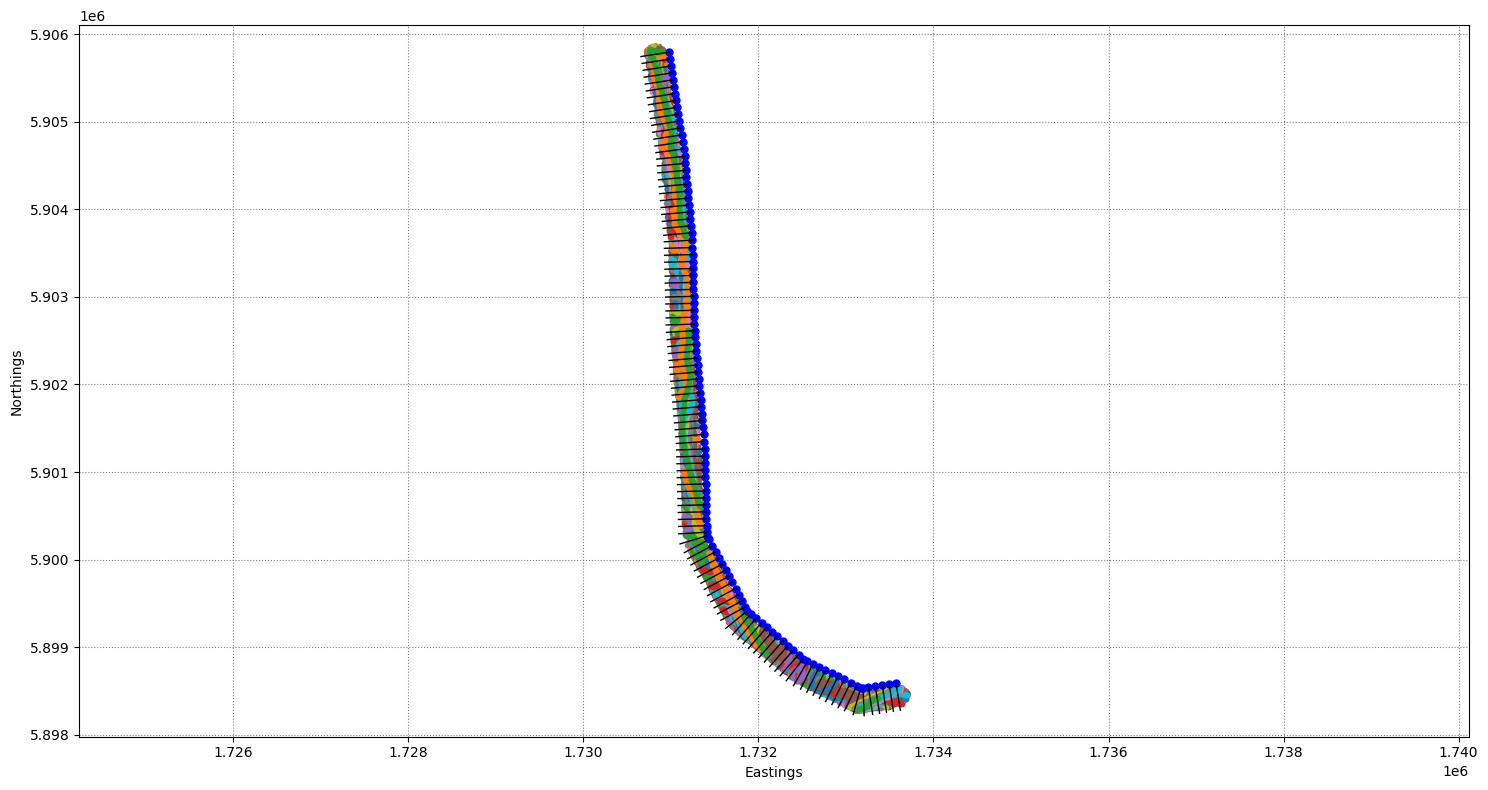

In [63]:
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    #plt.text(transects[key][0,0], transects[key][0,1], key.replace(f"{sitename}-0", ""),
    #            va='center', ha='center', bbox=dict(boxstyle="square", ec='k',fc='w'))
plt.show()

In [64]:
settings_transects = { # parameters for computing intersections
                      'along_dist':          25,        # along-shore distance to use for computing the intersection
                      'min_points':          3,         # minimum number of shoreline points to calculate an intersection
                      'max_std':             15,        # max std for points around transect
                      'max_range':           30,        # max range for points around transect
                      'min_chainage':        -100,      # largest negative value along transect (landwards of transect origin)
                      'multiple_inter':      'auto',    # mode for removing outliers ('auto', 'nan', 'max')
                      'auto_prc':            0.1,       # percentage of the time that multiple intersects are present to use the max
                     }
cross_distance = SDS_transects.compute_intersection_QC(output, transects, settings_transects) 

Computing transect shoreline intersections:   0%|          | 0/111 [00:00<?, ?it/s]

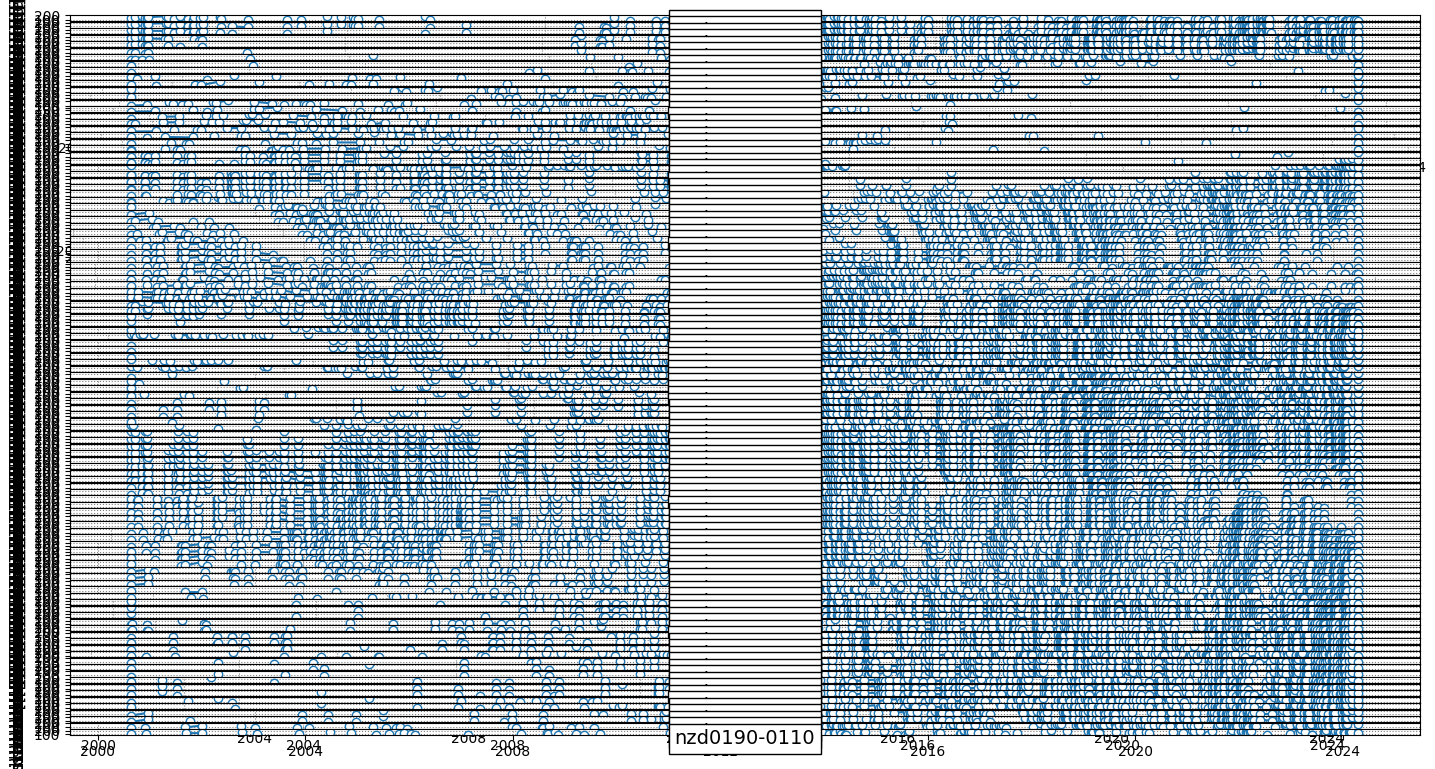

In [67]:
fig = plt.figure(figsize=[15,8], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(output['dates'], cross_distance[key], '-o', ms=6, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)
plt.show()

In [69]:
# save a .csv file for Excel users
out_dict = dict([])
out_dict['dates'] = output['dates']
out_dict["satname"] = output["satname"]
for key in transects.keys():
    out_dict[key] = cross_distance[key]
df = pd.DataFrame(out_dict)
fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                  'transect_time_series.csv')
#df.to_csv(fn, sep=',')
#print('Time-series of the shoreline change along the transects saved as:\n%s'%fn)
df

,dates,satname,nzd0190-0000,nzd0190-0001,nzd0190-0002,nzd0190-0003,nzd0190-0004,nzd0190-0005,nzd0190-0006,nzd0190-0007,...,nzd0190-0101,nzd0190-0102,nzd0190-0103,nzd0190-0104,nzd0190-0105,nzd0190-0106,nzd0190-0107,nzd0190-0108,nzd0190-0109,nzd0190-0110
0,1999-08-26 22:05:08+00:00,L7,139.328944,157.973249,185.444283,172.022753,142.360834,92.478743,72.393561,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-09-27 22:05:12+00:00,L7,154.837012,175.661171,175.337386,182.468012,155.884547,99.730804,75.685153,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1999-11-14 22:05:06+00:00,L7,196.830229,208.536946,211.601604,193.387847,161.279659,NaN,83.618446,80.812516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1999-12-09 21:58:57+00:00,L7,137.492173,149.117058,161.053969,143.234062,108.798090,71.016256,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1999-12-25 21:58:52+00:00,L7,145.304879,158.316590,161.296932,144.884043,104.732819,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,2024-05-11 22:05:15+00:00,L8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,131.616111,128.688956,143.579016,151.801221,159.206710,169.620634,167.265629,175.814090,170.365357,NaN
449,2024-05-18 22:11:19+00:00,L8,79.817199,101.638728,127.190884,149.604351,175.293306,198.593037,NaN,NaN,...,109.915245,107.404472,138.147427,161.986001,167.579305,173.889596,180.009323,185.028980,195.978579,NaN
450,2024-06-03 22:11:17+00:00,L8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,127.204790,135.229203,137.730686,148.890841,166.472096,NaN,NaN,NaN,NaN,NaN
451,2024-06-27 22:11:16+00:00,L9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,183.643769,202.359265,200.103860,187.144282,182.290468,201.473785,205.104036,201.081334,NaN,NaN


In [72]:
df.set_index("dates", inplace=True)
df.index = pd.to_datetime(df.index)

In [74]:
diff = (df-vos)
diff["satname"] = df.satname
diff

,nzd0190-0000,nzd0190-0001,nzd0190-0002,nzd0190-0003,nzd0190-0004,nzd0190-0005,nzd0190-0006,nzd0190-0007,nzd0190-0008,nzd0190-0009,...,nzd0190-0102,nzd0190-0103,nzd0190-0104,nzd0190-0105,nzd0190-0106,nzd0190-0107,nzd0190-0108,nzd0190-0109,nzd0190-0110,satname
dates,,,,,,,,,,,,,,,,,,,,,
1999-08-26 22:05:08+00:00,-57.383478,-62.274524,-62.022732,NaN,-54.140807,-52.339809,-31.660923,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L7
1999-09-27 22:05:12+00:00,-46.160007,-48.056544,-58.195407,NaN,-40.972876,-42.805615,-29.119441,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L7
1999-11-14 22:05:06+00:00,NaN,NaN,NaN,NaN,-67.972784,NaN,-39.419618,-33.850388,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L7
1999-12-09 21:58:57+00:00,-43.648525,-47.423766,-52.926773,-51.479271,-46.079644,-25.141492,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L7
1999-12-25 21:58:52+00:00,-53.324869,-60.910504,-58.443880,-54.461619,-48.923601,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-11 22:05:15+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L8
2024-05-18 22:11:19+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L8
2024-06-03 22:11:17+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L8


In [ ]:
df.shape, vos.shape

((1, 15), (538, 15))

In [ ]:
transects_gdf.to_crs(2193, inplace=True)
transects_gdf

,site_id,orientation,along_dist,along_dist_norm,beach_slope,cil,ciu,trend,n_points,n_points_nonan,geometry
id,,,,,,,,,,,
nzd0188-0000,nzd0188,57.067769,0.000000,0.000000,0.085,0.0728,0.1053,-0.012672,538.0,378.0,"LINESTRING (1854071.655 5902538.559, 1854345.3..."
nzd0188-0001,nzd0188,57.067769,100.000000,0.071452,0.130,0.1003,0.1945,0.013116,538.0,398.0,"LINESTRING (1854113.123 5902470.424, 1854386.7..."
nzd0188-0002,nzd0188,57.028924,200.000000,0.142905,0.125,0.0984,0.1630,0.171418,538.0,397.0,"LINESTRING (1854154.648 5902402.197, 1854428.2..."
nzd0188-0003,nzd0188,56.205388,299.998143,0.214356,0.095,0.0832,0.1136,0.250361,538.0,402.0,"LINESTRING (1854197.414 5902332.171, 1854468.5..."
nzd0188-0004,nzd0188,55.420712,399.998143,0.285809,0.105,0.0915,0.1195,0.122757,538.0,413.0,"LINESTRING (1854242.007 5902263.411, 1854510.7..."
nzd0188-0005,nzd0188,55.420712,499.998143,0.357261,0.100,0.0897,0.1136,0.180411,538.0,407.0,"LINESTRING (1854285.422 5902196.491, 1854554.2..."
nzd0188-0006,nzd0188,54.557443,599.998143,0.428713,0.100,0.0876,0.1149,-0.051175,538.0,406.0,"LINESTRING (1854330.16 5902127.566, 1854596.29..."
nzd0188-0007,nzd0188,52.909255,699.956883,0.500136,0.100,0.0896,0.1151,0.057596,538.0,403.0,"LINESTRING (1854378.17 5902058.231, 1854639.08..."
nzd0188-0008,nzd0188,52.125016,799.956883,0.571589,0.100,0.0903,0.1147,-0.109327,538.0,397.0,"LINESTRING (1854426.655 5901992.138, 1854685.0..."


In [ ]:
df

,nzd0188-0000,nzd0188-0001,nzd0188-0002,nzd0188-0003,nzd0188-0004,nzd0188-0005,nzd0188-0006,nzd0188-0007,nzd0188-0008,nzd0188-0009,nzd0188-0010,nzd0188-0011,nzd0188-0012,nzd0188-0013,nzd0188-0014
dates,,,,,,,,,,,,,,,
2003-07-21 21:42:33+00:00,162.201613,164.199007,157.843452,154.065102,152.647445,151.892519,151.655191,157.145119,156.827381,155.351341,149.795291,152.839015,155.484077,149.513322,154.257878


In [ ]:
#df = pd.read_csv("data/nzd0188/transect_time_series.csv")
#df.drop(columns="Unnamed: 0", inplace=True)
#df.set_index("dates", inplace=True)
my_intersects = df.loc["2003-07-21 21:42:33+00:00"]
my_intersects

nzd0188-0000    167.266514
nzd0188-0001    166.811628
nzd0188-0002    163.109041
nzd0188-0003    157.966514
nzd0188-0004    157.135436
nzd0188-0005    154.222598
nzd0188-0006    153.788779
nzd0188-0007    158.282499
nzd0188-0008    160.121379
nzd0188-0009    157.458554
nzd0188-0010    149.342672
nzd0188-0011    155.762760
nzd0188-0012    156.385227
nzd0188-0013    150.999714
nzd0188-0014    153.568590
Name: 2003-07-21 21:42:33+00:00, dtype: float64

In [ ]:
vos_intersects = vos.loc["2003-07-21 21:42:33+00:00"]
vos_intersects

nzd0188-0000    207.039370
nzd0188-0001    197.955344
nzd0188-0002    194.805314
nzd0188-0003    186.587322
nzd0188-0004    185.022602
nzd0188-0005    183.966109
nzd0188-0006    180.446069
nzd0188-0007    181.399493
nzd0188-0008    190.490556
nzd0188-0009    184.743819
nzd0188-0010    183.521960
nzd0188-0011    184.156911
nzd0188-0012    181.139068
nzd0188-0013    178.159517
nzd0188-0014    173.881791
Name: 2003-07-21 21:42:33+00:00, dtype: float64

In [ ]:
(my_intersects - vos_intersects).mean()

-28.739555942500033

In [ ]:
from shapely import line_interpolate_point
my_intersect_points = gpd.GeoSeries(transects_gdf.index.to_series().apply(lambda transect_id: line_interpolate_point(transects_gdf.geometry[transect_id], my_intersects[transect_id])), crs=transects_gdf.crs)
vos_intersect_points = gpd.GeoSeries(vos_intersects.index.to_series().apply(lambda transect_id: line_interpolate_point(transects_gdf.geometry[transect_id], vos_intersects[transect_id])), crs=transects_gdf.crs)
my_intersect_points, vos_intersect_points

(id
 nzd0188-0000     POINT (1854214.878 5902624.96)
 nzd0188-0001    POINT (1854255.958 5902556.589)
 nzd0188-0002    POINT (1854294.255 5902486.544)
 nzd0188-0003    POINT (1854331.435 5902415.789)
 nzd0188-0004    POINT (1854374.173 5902348.403)
 nzd0188-0005    POINT (1854415.139 5902279.907)
 nzd0188-0006    POINT (1854458.246 5902212.682)
 nzd0188-0007    POINT (1854507.429 5902149.585)
 nzd0188-0008     POINT (1854556.14 5902086.331)
 nzd0188-0009    POINT (1854601.101 5902020.513)
 nzd0188-0010    POINT (1854634.757 5901947.952)
 nzd0188-0011    POINT (1854680.873 5901882.306)
 nzd0188-0012    POINT (1854728.967 5901818.498)
 nzd0188-0013    POINT (1854774.903 5901752.785)
 nzd0188-0014    POINT (1854829.072 5901694.099)
 Name: id, dtype: geometry,
 nzd0188-0000    POINT (1854248.934 5902645.504)
 nzd0188-0001    POINT (1854282.625 5902572.676)
 nzd0188-0002    POINT (1854321.385 5902502.934)
 nzd0188-0003    POINT (1854355.717 5902430.939)
 nzd0188-0004    POINT (1854397.629 5

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -inf, 'width': 44, 'height': 51, 'count': 6, 'crs': CRS.from_epsg(32660), 'transform': Affine(30.0, 0.0, 397905.0,
       0.0, -30.0, -4093875.0)}


Text(0.5, 1.0, '2003-07-21-21-42-33_L5_nzd0188_ms.tif')

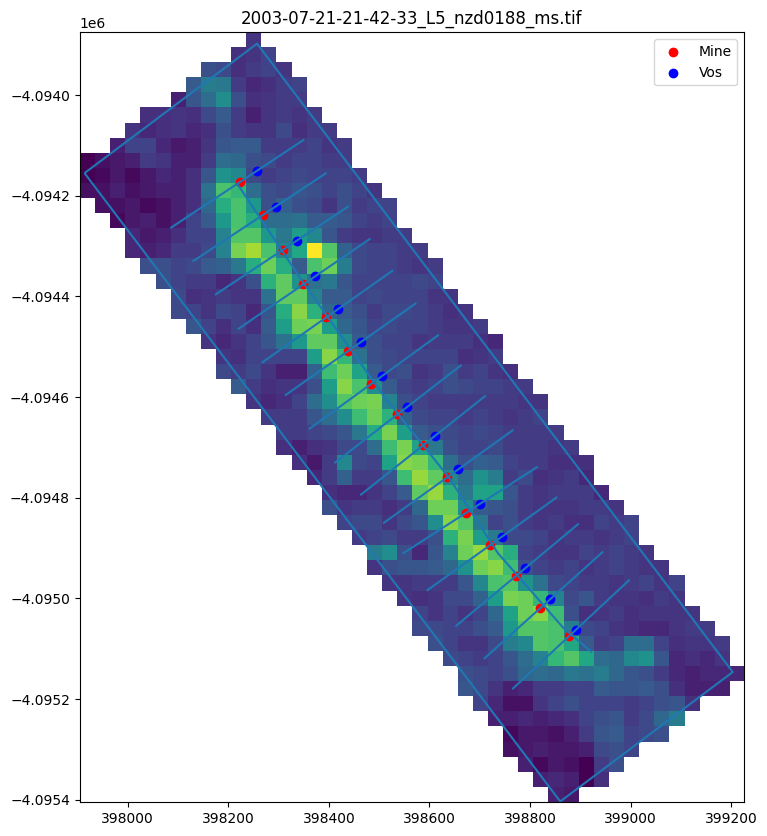

In [ ]:
import rasterio as rio
from rasterio.plot import show
src = rio.open("data_CoastSatV1/nzd0188/L5/30m/2003-07-21-21-42-33_L5_nzd0188.tif")
print(src.meta)
fig, ax = plt.subplots(figsize=(10,10))
# transform rasterio plot to real world coords
extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax = show(src, extent=extent, ax=ax, adjust=True)
transects_gdf.to_crs(src.crs).plot(ax=ax)
gpd.GeoSeries([shorelines.geometry[sitename], poly.geometry[sitename].exterior], crs=shorelines.crs).to_crs(src.crs).plot(ax=ax)
my_intersect_points.to_crs(src.crs).plot(ax=ax, color="red", label="Mine")
vos_intersect_points.to_crs(src.crs).plot(ax=ax, color="blue", label="Vos")
plt.legend()
plt.title("2003-07-21-21-42-33_L5_nzd0188_ms.tif")

In [48]:
sitename = "nzd0202"
df = pd.read_csv(f"data/{sitename}/transect_time_series.csv")
df.drop(columns="Unnamed: 0", inplace=True)
df.set_index("dates", inplace=True)
df.index = pd.to_datetime(df.index)
vos = pd.read_csv(f"shoreline_data_run6/New_Zealand/{sitename}/time_series_raw.csv")
vos.drop(columns="Unnamed: 0", inplace=True)
vos.set_index("dates", inplace=True)
vos.index = pd.to_datetime(vos.index)

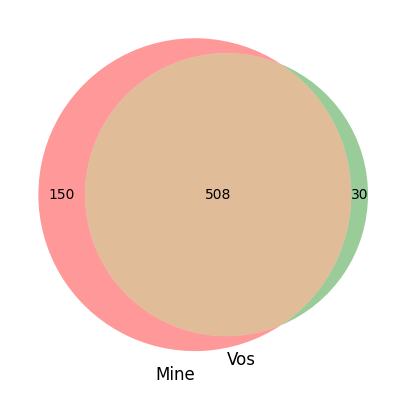

In [24]:
venn2([set(df.index), set(vos.index)], set_labels=('Mine', 'Vos'))
plt.show()

In [25]:
(df - vos).describe()

,nzd0188-0000,nzd0188-0001,nzd0188-0002,nzd0188-0003,nzd0188-0004,nzd0188-0005,nzd0188-0006,nzd0188-0007,nzd0188-0008,nzd0188-0009,nzd0188-0010,nzd0188-0011,nzd0188-0012,nzd0188-0013,nzd0188-0014
count,313.000000,362.000000,365.000000,364.000000,373.000000,362.000000,363.000000,361.000000,354.000000,362.000000,351.000000,330.000000,327.000000,372.000000,359.000000
mean,-42.547841,-37.237746,-36.594121,-35.735159,-34.705416,-34.575251,-33.780429,-33.689182,-32.503965,-31.879039,-33.346500,-34.534362,-32.892484,-32.612420,-28.117479
std,10.853847,8.641365,8.952174,8.000897,7.813072,7.803680,8.334921,8.186374,8.015841,8.105734,7.415205,7.590233,7.880340,8.209869,9.276045
min,-75.749485,-72.970338,-73.933307,-70.587738,-68.899096,-66.103286,-68.786126,-60.704340,-56.509572,-59.751281,-54.887669,-59.073069,-63.140956,-65.558514,-48.962304
25%,-49.694369,-42.874328,-42.137045,-41.204098,-39.794011,-39.890931,-38.321046,-39.066152,-37.411415,-36.895819,-38.373812,-39.484814,-38.223150,-37.775234,-33.685279
50%,-42.442979,-37.066757,-37.121766,-36.017503,-34.588101,-34.928125,-33.766372,-33.699150,-32.540550,-32.271906,-33.670157,-34.548963,-32.041498,-32.680253,-28.156456
75%,-35.496098,-31.430259,-30.549117,-30.226880,-29.361483,-28.594278,-28.173593,-28.258146,-27.281044,-26.626082,-28.349051,-29.330000,-27.396372,-27.541911,-22.957261
max,33.109490,-12.890202,42.065266,-5.081912,2.175228,-14.077131,16.915206,2.765421,23.367083,30.712392,-9.615602,-11.056760,-9.034264,-4.665174,39.032559


In [26]:
poly["done"] = poly.index.to_series().apply(lambda sitename: os.path.isdir(f"data/{sitename}"))
poly["have_ts"] = poly.index.to_series().apply(lambda sitename: os.path.isfile(f"data/{sitename}/transect_time_series.csv"))
poly["have_tides"] = poly.index.to_series().apply(lambda sitename: os.path.isfile(f"data/{sitename}/tides.csv"))
poly["have_tc"] = poly.index.to_series().apply(lambda sitename: os.path.isfile(f"data/{sitename}/transect_time_series_tidally_corrected.csv"))
poly.have_tc.value_counts()

have_tc
True    560
Name: count, dtype: int64

In [21]:
df = pd.DataFrame({"filename": sorted(glob("data/*/transect_time_series.csv"))})
df["sitename"] = df.filename.str.split("/").str[1]
df

,filename,sitename
0,data/nzd0001/transect_time_series.csv,nzd0001
1,data/nzd0002/transect_time_series.csv,nzd0002
2,data/nzd0003/transect_time_series.csv,nzd0003
3,data/nzd0004/transect_time_series.csv,nzd0004
4,data/nzd0005/transect_time_series.csv,nzd0005
...,...,...
555,data/nzd0557/transect_time_series.csv,nzd0557
556,data/nzd0558/transect_time_series.csv,nzd0558
557,data/nzd0559/transect_time_series.csv,nzd0559
558,data/nzd0560/transect_time_series.csv,nzd0560


In [13]:
df["start"] = df.filename.apply(lambda f: pd.read_csv(f).dates.min())
df["end"] = df.filename.apply(lambda f: pd.read_csv(f).dates.max())
df

,filename,sitename,start,end
0,data/nzd0001/transect_time_series.csv,nzd0001,1999-08-17 22:10:26+00:00,2024-08-05 22:17:06+00:00
1,data/nzd0002/transect_time_series.csv,nzd0002,1999-10-04 22:10:38+00:00,2024-08-05 22:17:06+00:00
2,data/nzd0003/transect_time_series.csv,nzd0003,1999-08-17 22:10:26+00:00,2024-08-05 22:17:06+00:00
3,data/nzd0004/transect_time_series.csv,nzd0004,1999-10-04 22:10:38+00:00,2024-07-12 22:17:00+00:00
4,data/nzd0005/transect_time_series.csv,nzd0005,1999-08-17 22:10:26+00:00,2024-07-12 22:17:00+00:00
...,...,...,...,...
555,data/nzd0557/transect_time_series.csv,nzd0557,1999-08-17 22:13:37+00:00,2024-08-05 22:20:42+00:00
556,data/nzd0558/transect_time_series.csv,nzd0558,1999-10-04 22:13:49+00:00,2024-08-12 22:26:33+00:00
557,data/nzd0559/transect_time_series.csv,nzd0559,1999-07-16 22:13:35+00:00,2024-08-05 22:20:18+00:00
558,data/nzd0560/transect_time_series.csv,nzd0560,1999-08-17 22:13:37+00:00,2024-08-05 22:20:42+00:00


In [103]:
all_dates = []
for f in df.filename:
  all_dates.extend(pd.read_csv(f).dates)
len(all_dates)

227693

In [116]:
all_dates = pd.to_datetime(all_dates).to_series()
all_dates

1999-08-17 22:10:26+00:00   1999-08-17 22:10:26+00:00
1999-10-04 22:10:38+00:00   1999-10-04 22:10:38+00:00
2000-04-29 22:09:53+00:00   2000-04-29 22:09:53+00:00
2000-06-16 22:09:26+00:00   2000-06-16 22:09:26+00:00
2000-08-03 22:08:44+00:00   2000-08-03 22:08:44+00:00
                                       ...           
2024-04-14 22:26:30+00:00   2024-04-14 22:26:30+00:00
2024-04-30 22:26:19+00:00   2024-04-30 22:26:19+00:00
2024-05-16 22:26:05+00:00   2024-05-16 22:26:05+00:00
2024-06-17 22:26:08+00:00   2024-06-17 22:26:08+00:00
2024-07-12 22:20:36+00:00   2024-07-12 22:20:36+00:00
Length: 227693, dtype: datetime64[ns, UTC]

<Axes: title={'center': 'Landsat acquisition by year'}>

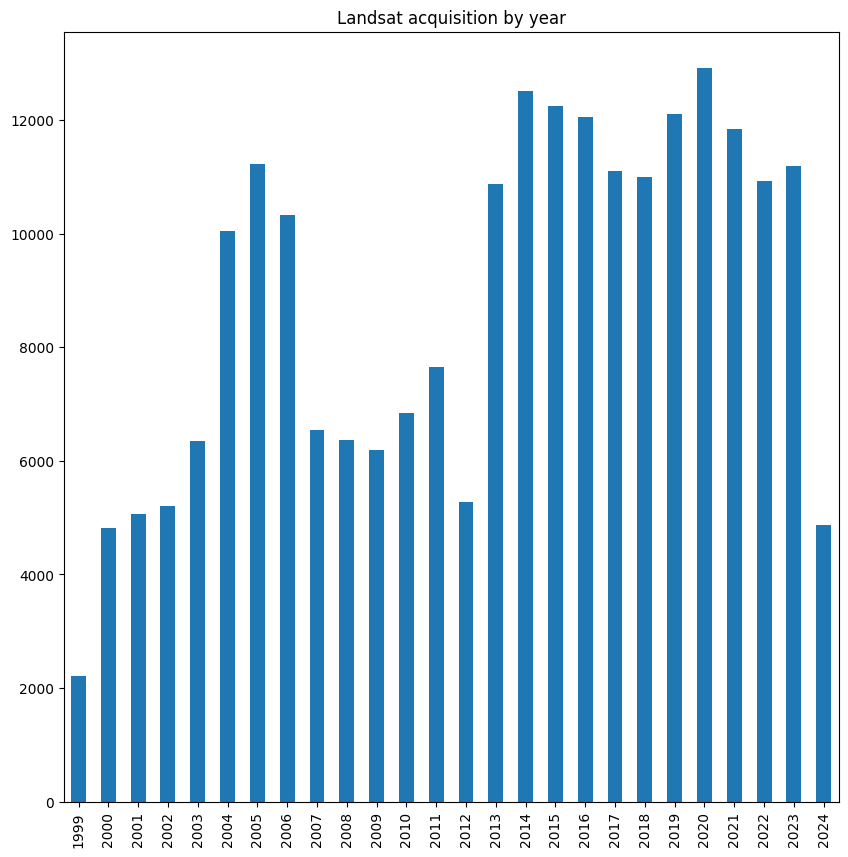

In [123]:
all_dates.groupby(all_dates.dt.year).count().plot.bar(figsize=(10,10), title="Landsat acquisition by year")

<Axes: xlabel='end'>

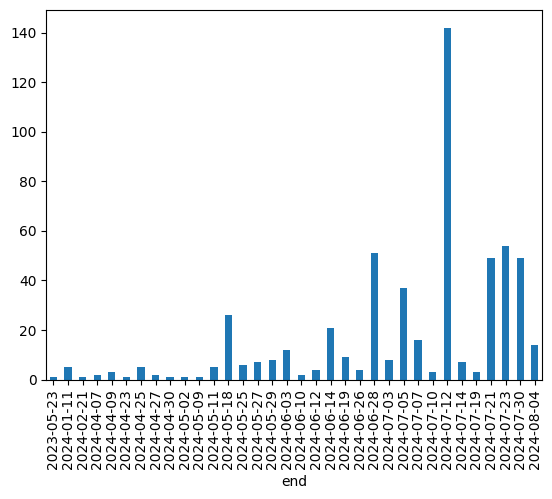

In [98]:
df.end = pd.to_datetime(df.end)
df.groupby(df.end.dt.date).end.count().plot(kind="bar")

In [22]:
def get_vos_diff(sitename):
    df = pd.read_csv(f"data/{sitename}/transect_time_series.csv")
    df.drop(columns="Unnamed: 0", inplace=True)
    df.set_index("dates", inplace=True)
    df.index = pd.to_datetime(df.index)
    vos = pd.read_csv(f"shoreline_data_run6/New_Zealand/{sitename}/time_series_raw.csv")
    vos.drop(columns="Unnamed: 0", inplace=True)
    vos.set_index("dates", inplace=True)
    vos.index = pd.to_datetime(vos.index)
    return (df - vos).mean(axis=1)

diff_result = df.sitename.apply(get_vos_diff)

<Axes: ylabel='Frequency'>

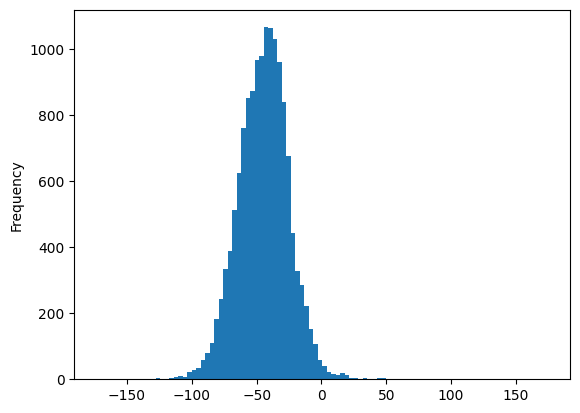

In [23]:
diff_result.mean().plot.hist(bins=100)

In [30]:
diff_result.mean().describe()

count    32004.000000
mean       -44.427875
std         21.820595
min       -357.977268
25%        -59.491487
50%        -42.821800
75%        -30.240118
max        181.798978
dtype: float64